<a href="https://colab.research.google.com/github/Drime648/Pet-Image-Segmenter/blob/main/image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-g8zf2ghq
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-g8zf2ghq


In [ ]:
import tensorflow as tf


In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [ ]:
dataset, info

({'test': <PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>,
  'train': <PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>},
 tfds.core.DatasetInfo(
     name='oxford_iiit_pet',
     version=3.2.0,
     description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
 images for each class. The images have large variations in scale, pose and
 lighting. All images have an associated ground truth annotation of breed.',
     homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
     features=FeaturesDict({
         'file_name': Text(shape=(), dtype=tf.string),
         'image': Image(shape=

In [ ]:
def normalize(input_img, input_mask):
  input_img = tf.cast(input_img, tf.float32) / 255.0
  input_mask -= 1
  return input_img, input_mask


In [ ]:
def load_train_img(data):
  input_img = tf.image.resize(data['image'], (128, 128))
  input_mask = tf.image.resize(data['segmentation_mask'], (128,128))
  if tf.random.uniform(()) > 0.5:
    input_img = tf.image.flip_left_right(input_img)
    input_mask = tf.image.flip_left_right(input_mask)

  input_img, input_mask = normalize(input_img=input_img,
                                    input_mask=input_mask)
  
  return input_img, input_mask
  
  




In [ ]:
tf.random.uniform(())

<tf.Tensor: shape=(), dtype=float32, numpy=0.7852843>

In [ ]:
def load_test_img(data):
  input_img = tf.image.resize(data['image'], (128, 128))
  input_mask = tf.image.resize(data['segmentation_mask'], (128,128))

  input_img, input_mask = normalize(input_img=input_img,
                                    input_mask=input_mask)
  
  return input_img, input_mask

In [ ]:
train_len = info.splits['train'].num_examples
batch_size = 32

In [ ]:
train_data = dataset['train'].map(load_train_img, num_parallel_calls = tf.data.AUTOTUNE)
test_data = dataset['test'].map(load_test_img, num_parallel_calls = tf.data.AUTOTUNE)


In [ ]:
train_data, test_data

(<ParallelMapDataset shapes: ((128, 128, 3), (128, 128, 1)), types: (tf.float32, tf.float32)>,
 <ParallelMapDataset shapes: ((128, 128, 3), (128, 128, 1)), types: (tf.float32, tf.float32)>)

In [ ]:
train_dataset = train_data.cache().shuffle(1000).batch(32).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_data.batch(32)


In [ ]:
train_dataset, test_dataset

(<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>,
 <BatchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>)

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

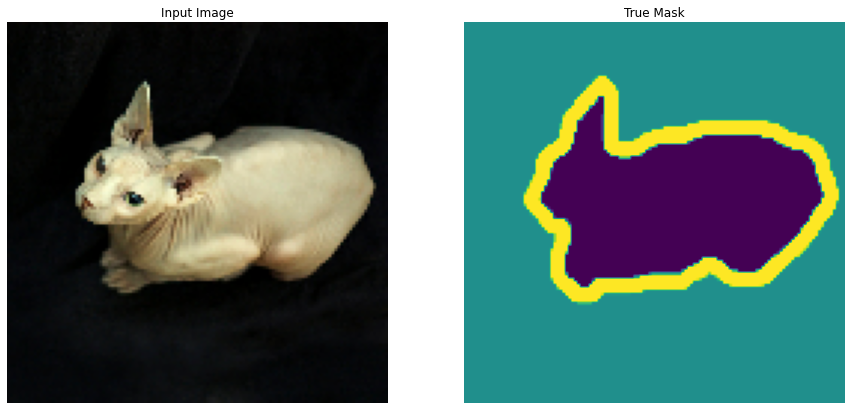

In [ ]:
for image, mask in train_data.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])


In [ ]:
OUTPUT_CHANNELS = 3
# 3 different classes for each pixel

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)
# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]


In [ ]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model_4 (Functional)            [(None, 64, 64, 96), 1841984     input_6[0][0]                    
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 8, 8, 512)    1476608     model_4[0][4]                    
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 8, 8, 1088)   0           sequential_8[0][0]               
                                                                 model_4[0][3]              

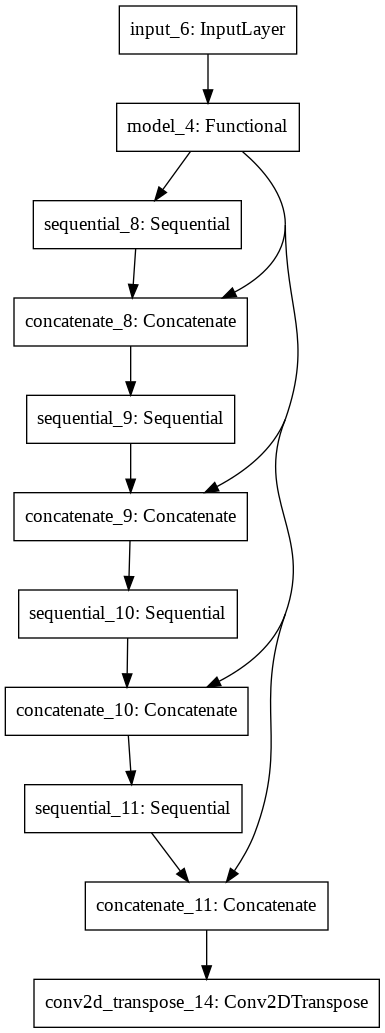

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

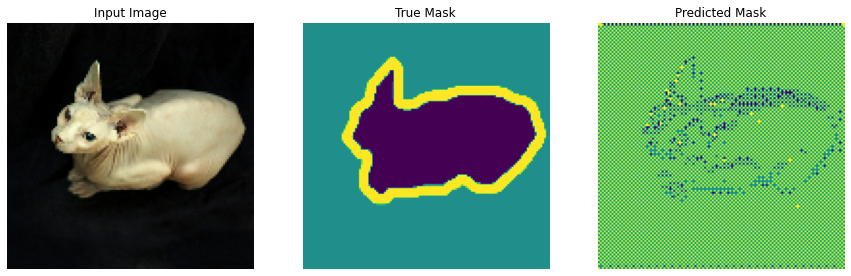

In [ ]:
show_predictions()

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions(test_dataset)
    print ('\nPrediction after epoch {}\n'.format(epoch+1))

In [ ]:
import os

def make_model_checkpoint(name, path = "/content/model_exp/"):
  return tf.keras.callbacks.ModelCheckpoint(os.path.join(path, name), save_best_only = True, verbose = 0)

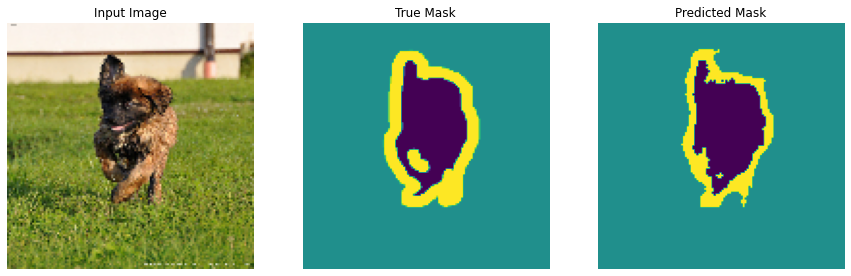


Prediction after epoch 20



In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//32//VAL_SUBSPLITS
TRAIN_LENGTH = info.splits['train'].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // 32

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), make_model_checkpoint('model')])

In [ ]:
model = tf.keras.models.load_model("/content/model_exp/model")

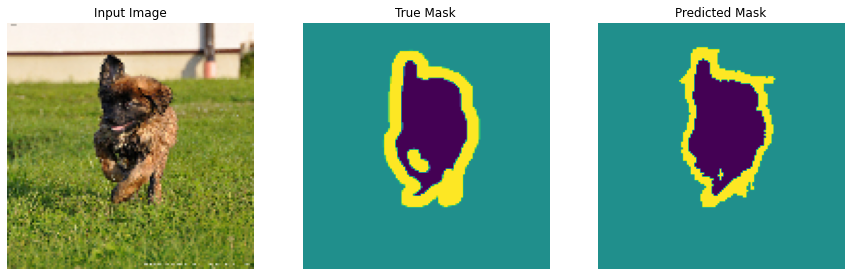

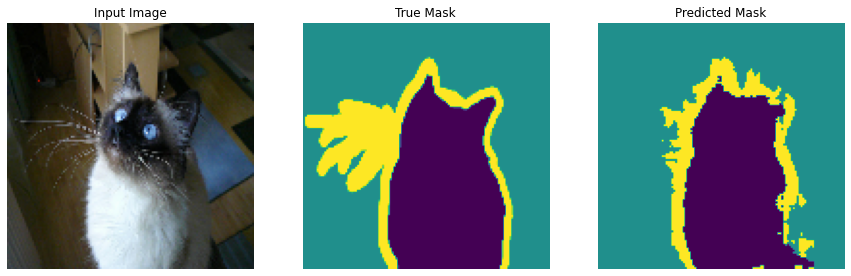

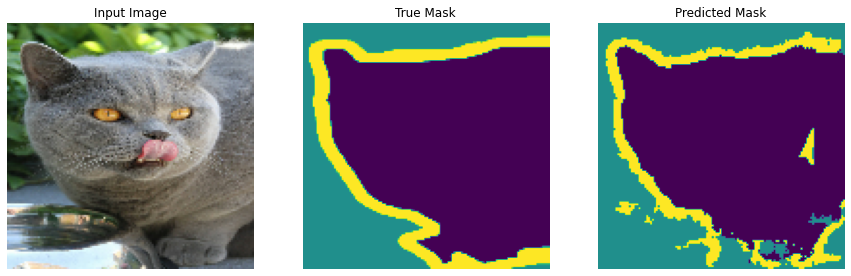

In [ ]:
show_predictions(test_dataset, 3)